# Coronavirus Playground

A place for coronavirus/covid-19 focused projects and random bits.

In [2]:
import datetime
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import numpy as np
import pandas as pd
from scipy.special import gamma
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression
import timeit


## Coronavirus in Vermont

In [3]:
total_cases = [1, 1, 1, 1, 1, 2, 2, 5, 8, 12, 14, 19, 22, 29, 49]
total_deaths = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2]
dates = [datetime.date(year=2020, month=3, day=7) + datetime.timedelta(days=i) 
         for i in range(len(total_cases))]
print('dates:', dates)
df = pd.DataFrame({
    'date': dates,
    'total_cases': total_cases,
    'total_deaths': total_deaths
}, index=dates)
df

dates: [datetime.date(2020, 3, 7), datetime.date(2020, 3, 8), datetime.date(2020, 3, 9), datetime.date(2020, 3, 10), datetime.date(2020, 3, 11), datetime.date(2020, 3, 12), datetime.date(2020, 3, 13), datetime.date(2020, 3, 14), datetime.date(2020, 3, 15), datetime.date(2020, 3, 16), datetime.date(2020, 3, 17), datetime.date(2020, 3, 18), datetime.date(2020, 3, 19), datetime.date(2020, 3, 20), datetime.date(2020, 3, 21)]


,date,total_cases,total_deaths
2020-03-07,2020-03-07,1,0
2020-03-08,2020-03-08,1,0
2020-03-09,2020-03-09,1,0
2020-03-10,2020-03-10,1,0
2020-03-11,2020-03-11,1,0
2020-03-12,2020-03-12,2,0
2020-03-13,2020-03-13,2,0
2020-03-14,2020-03-14,5,0
2020-03-15,2020-03-15,8,0
2020-03-16,2020-03-16,12,0


In [0]:
fig, ax = plt.subplots(figsize=(4,8))
plt.plot(df['date'], df['total_cases'], label='cases')
plt.plot(df['date'], df['total_deaths'], label='deaths')
plt.xticks(rotation=-90)
plt.title('Coronavirus Chart')
plt.ylabel('Total #')
plt.xlabel('Date')
plt.legend()
plt.show()


In [0]:

labels = df['date']
cases = df['total_cases']
deaths = df['total_deaths']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, cases, width, label='Cases')
rects2 = ax.bar(x + width/2, deaths, width, label='Deaths')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Total')
ax.set_title('Case and Death Totals by Date')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=-90)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

NameError: ignored

## Coronavirus Stimulus Bill 2020/03/27

This exploration was inspired by the discussion around Senator Graham (and others) observing that the 3rd stimulus bill expands uninsurance s.t. someone earning \$20 in SC would be earning \$24 if they were unemployed. The senators were concerned about the negative incentive to work. Here is a relevant NYTimes editorial:

https://www.nytimes.com/2020/03/25/opinion/coronavirus-stimulus-senate.html

Another NYTimes editorial mentions that the stimulus bill does not do enough to retain workers, and showcases the UK government's decision to pay 80% of worker salaries:

https://www.nytimes.com/2020/03/26/opinion/covid-economy-unemployment-europe.html

So let's dig in by asking questions:
- Does unemployment pay more than employment?
- How does the UK plan compare to the US unemployment (and basic income) plan?

In Massachusetts, one's weekly unemployment benefit is 50% of wages up to $823/week. Source: https://www.mass.gov/info-details/how-your-unemployment-benefits-are-determined

> If you are eligible to receive unemployment benefits, you will receive a weekly benefit amount of approximately 50% of your average weekly wage, up to the maximum set by law. As of October 2019, the maximum weekly benefit amount is \$823 per week.

In vermont, one's weekly benefit is 57.77777% (= 26 / 45) of wages up to \$513/week. See: https://vtdigger.org/2020/03/18/vermont-lawmakers-look-to-expand-eligibility-for-unemployment-benefits/

Looking at https://www.savingtoinvest.com/maximum-weekly-unemployment-benefits-by-state/, Arizona is almost the lowest maximum benefit state. One's weekly benefit is 52% of wages up to only \$240/wk.

In this exploration, MA approximates a bound on the maximum possible benefit, AZ on least possible benefit, and VT lies somewhat above average. (But let's be honest, VT and MA made it b/c I live in VT and I knew MA was higher than NY back in 2002 when I was unemployed in NYC and Zac in Boston.)

The New York Times gives a vague sense of the averages for UI (unemployment income) in the US:

> Benefits in normal times are calculated as a percentage of lost salary, typically around 45 percent, up to a maximum amount that varies by state. The national average is \$385 a week, which isn’t enough to keep a family above the poverty line. 

See https://www.nytimes.com/2020/03/25/opinion/coronavirus-stimulus-senate.html.

Knowing these benefit formulas, we can plot the relationship between hourly wage (assuming a 40 hour/wk job) and unemployment income. We can also find the point at which unemployment benefits equal or exceed full time income.

What are the amount of households which would earn more by being unemployed than being employed? To answer this question we will look at the *threshold wage* at which you earn as much or more through unemployment income than through employment. Arizona has a relatively low benefit max of \$240/wk. Vermont has higher than average maximum benefit of \$513/wk. And Massachusetts has one of the highest maximum benefits in the country, at \$823/wk.

The hourly wage threshold is:
- \$21.00 in AZ
- \$27.82 in VT
- \$30.00 in NY

Anyone earning this much or less would do earn as much or more on unemployment.

How many people fall under this threshold? https://en.wikipedia.org/wiki/Personal_income_in_the_United_States#Income_distribution

- ~64% of individuals earn <= 21.00/hr
- ~75% of individuals earn <= 27.82/hr
- ~77% of individuals earn <= 30.00/hr


What is the hourly wage at or below which one earns more being unemployed than employed?
vt_fed_ui_zero 27.82
ma_fed_ui_zero 30.0
az_fed_ui_zero 21.0


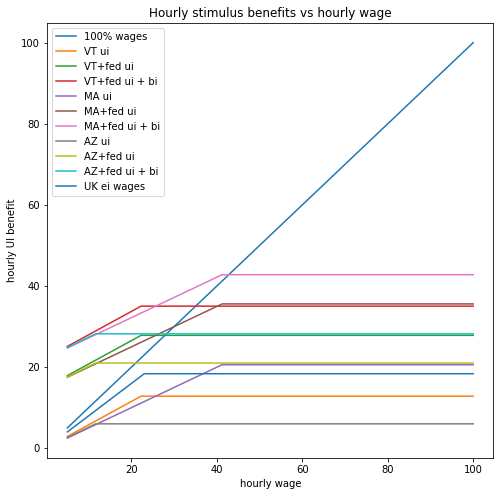

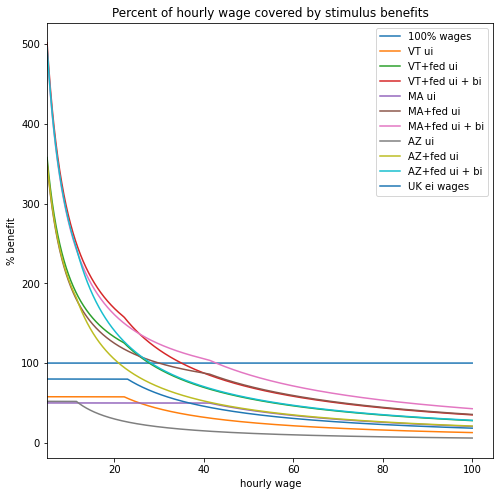

In [0]:
ma_ui_factor = 0.5  # 50%
ma_ui_max = 823 # weekly
vt_ui_factor = 26/45  # 57.8%
vt_ui_max = 513 # weekly
az_ui_max = 240 # weekly
az_ui_factor = (0.04 * 13)  # 52% weekly wage is 4% of quarterly wages. 


def vt_ui_benefit(hourly_wages):
    return np.minimum(hourly_wages * vt_ui_factor, vt_ui_max / 40)


def ma_ui_benefit(hourly_wages):
    return np.minimum(hourly_wages * ma_ui_factor, ma_ui_max / 40)


def az_ui_benefit(hourly_wages):
    return np.minimum(hourly_wages * az_ui_factor, az_ui_max / 40)


# consider a range of yearly/weekly/hourly wages
hourly_wages = np.linspace(5, 100, 95 * 100 + 1)
# print('hourly_wages', hourly_wages)
yearly_wages = hourly_wages * 40 * 50  # i.e. $20/hr => $40,000/year
weekly_wages = hourly_wages * 40

weekly_fed_ui = 600  # stimulus package adds $600/wk to unemployment
monthly_fed_bi = 1200  # federal monthly basic income for 1 adult
yearly_fed_bi = monthly_fed_bi * 12
hourly_fed_bi = yearly_fed_bi / 50 / 40 # i.e. $20/hr => $40,000/yr
vt_ui = vt_ui_benefit(hourly_wages)
vt_fed_ui = vt_ui + (weekly_fed_ui / 40)
vt_fed_ui_bi = vt_fed_ui + hourly_fed_bi
vt_fed_ui_zero = hourly_wages[(vt_fed_ui - hourly_wages) >= 0].max()
ma_ui = ma_ui_benefit(hourly_wages)
ma_fed_ui = ma_ui + (weekly_fed_ui / 40)
ma_fed_ui_bi = ma_fed_ui + hourly_fed_bi
ma_fed_ui_zero = hourly_wages[(ma_fed_ui - hourly_wages) >= 0].max()
az_ui = az_ui_benefit(hourly_wages)
az_fed_ui = az_ui + (weekly_fed_ui / 40)
az_fed_ui_bi = az_fed_ui + hourly_fed_bi
az_fed_ui_zero = hourly_wages[(az_fed_ui - hourly_wages) >= 0].max()

print('What is the hourly wage at or below which one earns more being unemployed than employed?')
print('vt_fed_ui_zero', vt_fed_ui_zero)
print('ma_fed_ui_zero', ma_fed_ui_zero)
print('az_fed_ui_zero', az_fed_ui_zero)

# UK stimulus = 80% wages up to a max of 2500 GBP/month
# https://www.theguardian.com/uk-news/2020/mar/20/government-pay-wages-jobs-coronavirus-rishi-sunak

gbp_to_usd = 1.224  # 1 GBP = 1.23 USD, on 3/27 8:45
monthly_uk_max = 2500 * gbp_to_usd
yearly_uk_max = monthly_uk_max * 12
hourly_uk_max = yearly_uk_max / 50 / 40
uk_wage_factor = 0.8
def uk_employment_benefit(hourly_wages):
    return np.minimum(hourly_wages * uk_wage_factor, hourly_uk_max)

uk_benefit = uk_employment_benefit(hourly_wages)

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hourly_wages, hourly_wages, label='100% wages')
plt.plot(hourly_wages, vt_ui, label='VT ui')
plt.plot(hourly_wages, vt_fed_ui, label='VT+fed ui')
plt.plot(hourly_wages, vt_fed_ui_bi, label='VT+fed ui + bi')
plt.plot(hourly_wages, ma_ui, label='MA ui')
plt.plot(hourly_wages, ma_fed_ui, label='MA+fed ui')
plt.plot(hourly_wages, ma_fed_ui_bi, label='MA+fed ui + bi')
plt.plot(hourly_wages, az_ui, label='AZ ui')
plt.plot(hourly_wages, az_fed_ui, label='AZ+fed ui')
plt.plot(hourly_wages, az_fed_ui_bi, label='AZ+fed ui + bi')
plt.plot(hourly_wages, uk_benefit, label='UK ei wages')
plt.xlabel('hourly wage')
plt.ylabel('hourly UI benefit')
plt.title('Hourly stimulus benefits vs hourly wage')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 8))
plt.plot(hourly_wages, 100 * hourly_wages / hourly_wages, label='100% wages')
plt.plot(hourly_wages, 100 * vt_ui / hourly_wages, label='VT ui')
plt.plot(hourly_wages, 100 * vt_fed_ui / hourly_wages, label='VT+fed ui')
plt.plot(hourly_wages, 100 * vt_fed_ui_bi / hourly_wages, label='VT+fed ui + bi')
plt.plot(hourly_wages, 100 * ma_ui / hourly_wages, label='MA ui')
plt.plot(hourly_wages, 100 * ma_fed_ui / hourly_wages, label='MA+fed ui')
plt.plot(hourly_wages, 100 * ma_fed_ui_bi / hourly_wages, label='MA+fed ui + bi')
plt.plot(hourly_wages, 100 * az_ui / hourly_wages, label='AZ ui')
plt.plot(hourly_wages, 100 * az_fed_ui / hourly_wages, label='AZ+fed ui')
plt.plot(hourly_wages, 100 * az_fed_ui_bi / hourly_wages, label='AZ+fed ui + bi')
plt.plot(hourly_wages, 100 * uk_benefit / hourly_wages, label='UK ei wages')
plt.xlim(left=5)
plt.xlabel('hourly wage')
plt.ylabel('% benefit')
plt.title('Percent of hourly wage covered by stimulus benefits')
plt.legend()
plt.show()
